In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [3]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanAbsolutePercentageError
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf

In [4]:
# JSON 로드 (Harris 예제를 기준으로)
with open('/content/drive/MyDrive/[인공지능기초]/predict/youtube/vader/vader_sentiment_analysis_harris.json', 'r') as f:
    harris_data = json.load(f)

In [5]:
harris_df = pd.DataFrame(list(harris_data.items()), columns=['date', 'score'])
harris_df['date'] = pd.to_datetime(harris_df['date'])
harris_df.set_index('date', inplace=True)
harris_df.sort_index(inplace=True)

harris_data_values = harris_df[['score']].values
scaler = MinMaxScaler((0,1))
scaled_values = scaler.fit_transform(harris_data_values)

In [6]:
def create_dataset(dataset, look_back=7):
    X, y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:i+look_back, 0])
        y.append(dataset[i+look_back, 0])
    return np.array(X), np.array(y)

In [7]:
look_back = 7
X, y = create_dataset(scaled_values, look_back)
train_size = int(len(X)*0.9)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [8]:
# 하이퍼파라미터 검색을 위한 모델 빌드 함수 (LSTM 레이어 1개만 사용)
def build_model(hp):
    model = Sequential()
    # 단일 LSTM 레이어
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
    hp_dropout = hp.Float('dropout', 0.0, 0.5, step=0.1)

    model.add(LSTM(hp_units, input_shape=(look_back, 1),
                   dropout=hp_dropout, recurrent_dropout=hp_dropout))
    model.add(Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    return model

In [9]:
# Keras Tuner 사용 (Hyperband)
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='harris_tuning_single_LSTM'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             callbacks=[early_stop],
             verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
print(f"units: {best_hps.get('units')}")
print(f"dropout: {best_hps.get('dropout')}")
print(f"learning_rate: {best_hps.get('learning_rate')}")

Trial 30 Complete [00h 00m 05s]
val_loss: 0.010886196047067642

Best val_loss So Far: 0.010236905887722969
Total elapsed time: 00h 01m 53s
Best hyperparameters:
units: 96
dropout: 0.1
learning_rate: 0.001


In [10]:
# 최적 하이퍼파라미터로 모델 빌드
model = tuner.hypermodel.build(best_hps)

model_checkpoint = ModelCheckpoint('best_model_harris.keras', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=16,
                    callbacks=[early_stop, model_checkpoint],
                    verbose=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.2337 - val_loss: 0.1617
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0872 - val_loss: 0.0222
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0492 - val_loss: 0.0105
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0607 - val_loss: 0.0202
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0452 - val_loss: 0.0403
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0383 - val_loss: 0.0400
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0358 - val_loss: 0.0262
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0324 - val_loss: 0.0205


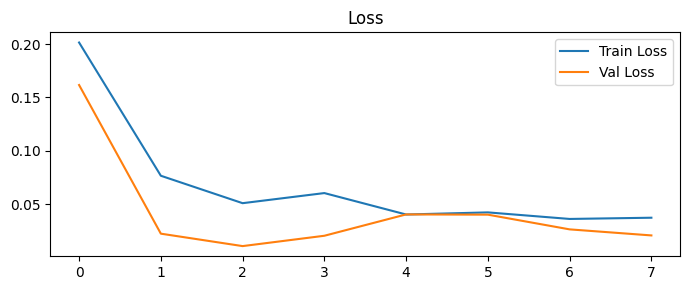

[0.20153407752513885, 0.07653586566448212, 0.050796691328287125, 0.06027935445308685, 0.04017031937837601, 0.042156193405389786, 0.036006148904561996, 0.037156492471694946]


In [24]:
# 학습 과정 시각화
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(history.history['loss'], label='Train Loss')
ax.plot(history.history['val_loss'], label='Val Loss')
ax.set_title("Loss")
ax.legend()

plt.tight_layout()
plt.show()

print(history.history['loss'])

In [12]:
# 최종 모델 로드
best_model = tf.keras.models.load_model('best_model_harris.keras')

In [13]:
# 예측
future_dates = pd.date_range(start='2024-11-05', periods=3, freq='D')
last_sequence = scaled_values[-look_back:]
current_input = last_sequence.reshape((1, look_back, 1))
predictions = []
for i in range(3):
    pred = best_model.predict(current_input, verbose=0)
    predictions.append(pred[0,0])
    current_input = np.append(current_input[:,1:,:], [[[pred[0,0]]]], axis=1)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
prediction_df = pd.DataFrame(predictions, index=future_dates, columns=['predicted_score'])

print(prediction_df)

            predicted_score
2024-11-05         0.296354
2024-11-06         0.310585
2024-11-07         0.310652


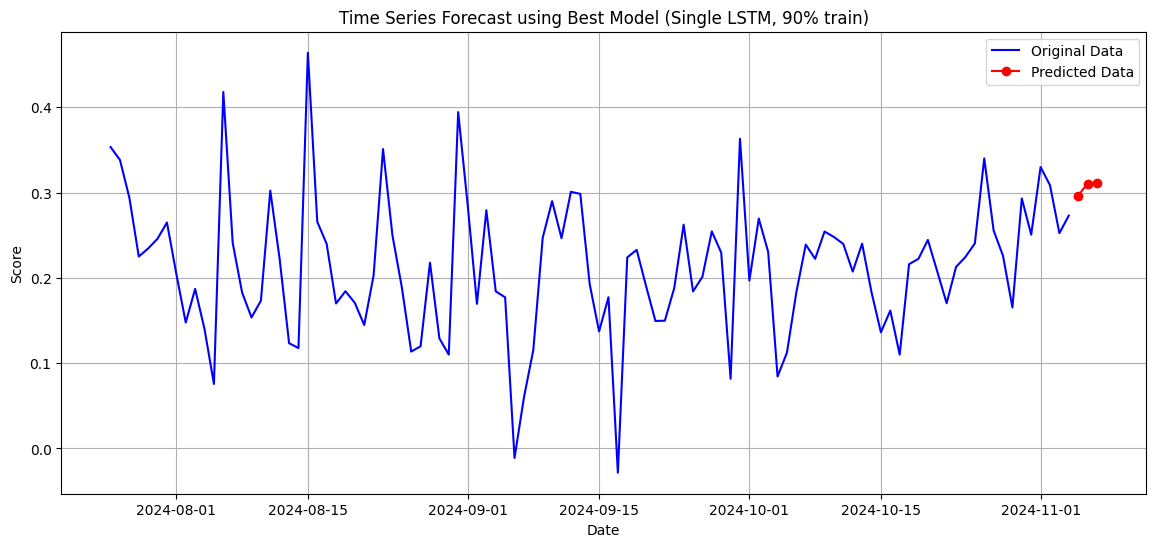

In [14]:
# 시각화
plt.figure(figsize=(14, 6))
plt.plot(harris_df.index, harris_df['score'], label='Original Data', color='blue')
plt.plot(prediction_df.index, prediction_df['predicted_score'], label='Predicted Data', color='red', marker='o')
plt.title('Time Series Forecast using Best Model (Single LSTM, 90% train)')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()